# 常用库

In [1]:
import torch 
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import random
import requests 
import math
#from pandarallel import pandarallel
from scipy import stats
#from bs4 import BeautifulSoup

## 分类任务
import sklearn.neighbors 
from sklearn.neighbors import KNeighborsClassifier  # K近邻
import sklearn.svm
from sklearn.svm import SVC  # 支持向量机
from sklearn.svm import OneClassSVM  # 
import sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB  # 朴素贝叶斯
import sklearn.tree  
from sklearn.tree import DecisionTreeClassifier  # 决策树
import sklearn.ensemble  
from sklearn.ensemble import BaggingClassifier  # 装袋法
from sklearn.ensemble import RandomForestClassifier  # 随机森林
import sklearn.neural_network
from sklearn.neural_network import MLPClassifier  # 神经网络
from sklearn.linear_model import LogisticRegression  # 逻辑回归
from sklearn.preprocessing import PolynomialFeatures  # 多项式回归
import sklearn.metrics
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_predict

from sklearn.manifold import TSNE,Isomap,MDS

from sklearn.decomposition import PCA  # 主成分分析
from sklearn.decomposition import TruncatedSVD  # 截断SVD和LSA
from sklearn.decomposition import SparseCoder # 字典学习
from sklearn.decomposition import FactorAnalysis # 因子分析
from sklearn.decomposition import FastICA  # 独立成分分析  
from sklearn.decomposition import NMF  # 非负矩阵分解
from sklearn.decomposition import LatentDirichletAllocation  # LDA

#gpus = tf.config.experimental.list_physical_devices(device_type="GPU")

#tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6096)])

# 优秀DL模型框架

## DeepKme针对Rm1（DL改良版）

In [38]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.compile(optimizer=tf.optimizers.Adam()
                     ,loss=tf.losses.BinaryCrossentropy()
                     ,metrics=[tf.metrics.AUC(1000)]
                    )
        
        self.cnn1 = tf.keras.Sequential([
            tf.keras.layers.Reshape([51,21]),
            tf.keras.layers.Conv1D(64,6,1,"valid"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),
            tf.keras.layers.MaxPool1D(),
            tf.keras.layers.AlphaDropout(0.5),
            #tf.keras.layers.Reshape([23*64]),
        ])
        self.cnn2 = tf.keras.Sequential([
           # tf.keras.layers.Reshape([23,64]),
            tf.keras.layers.Conv1D(32,4,1,"valid"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),
            tf.keras.layers.MaxPool1D(),
            #tf.keras.layers.AlphaDropout(0.5),
            tf.keras.layers.Reshape([10*32]),
        ])

        self.simple = tf.keras.Sequential([
            tf.keras.layers.Dense(64),
            tf.keras.layers.PReLU(),
            tf.keras.layers.Dense(16,kernel_regularizer="l2"),
            tf.keras.layers.PReLU(),
            tf.keras.layers.Dense(1,activation="sigmoid"),
        ])
    def call(self, inputs):
        
        c1 = self.cnn1(inputs)
        c2 = self.cnn2(c1)
        #c3 = self.cnn3(c2)
        #x = tf.keras.layers.Concatenate()([c2,c3])
        x = self.simple(c2)
        
        return x
    
model = Model()
model.build((None,51*21))
model.summary()
#很好 分为类别加权1：5和不加权对Rm1分别进行测试，结果十折结果已测试。包括十折交叉验证的验证集（但不调超参数）、测试集、以及非冗余测试集结果

ERROR! Session/line number was not unique in database. History logging moved to new session 409
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  11328     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  8992      
_________________________________________________________________
sequential_2 (Sequential)    multiple                  21681     
Total params: 42,001
Trainable params: 41,809
Non-trainable params: 192
_________________________________________________________________


## DeepKme单任务版（DL原始版）

In [7]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.compile(optimizer=tf.optimizers.Adam()
                     ,loss=tf.losses.BinaryCrossentropy()
                     ,metrics=[tf.metrics.AUC(1000)]
                    )
        
        self.cnn1 = tf.keras.Sequential([
            tf.keras.layers.Reshape([51,21]),
            tf.keras.layers.Conv1D(256,9,1,"valid"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool1D(),
            tf.keras.layers.Dropout(0.7),
        ])
        self.cnn2 = tf.keras.Sequential([
            tf.keras.layers.Reshape([21,256]),
            tf.keras.layers.Conv1D(32,7,1,"valid"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool1D(),
            tf.keras.layers.Dropout(0.5),
        ])
        self.simple = tf.keras.Sequential([
            tf.keras.layers.Reshape([7*32]),
            tf.keras.layers.Dense(128),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(1,activation="sigmoid"),
        ])
    def call(self, inputs):
        
        x = self.cnn1(inputs)
        x = self.cnn2(x)
        x = self.simple(x)
        
        return x
    
model = Model()
model.build((None,51*21))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  49664     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  57504     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  28929     
Total params: 136,097
Trainable params: 135,521
Non-trainable params: 576
_________________________________________________________________


# 传统机器学习模型

## RandomForestClassifier

In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = RandomForestClassifier()

    model.fit(x_train_m1_list[i],y_train_m1_list[i].ravel())

    torch.save(model,f"./Model/m1_RF_{i+1}.hdf5")

    model = torch.load(f"./Model/m1_RF_{i+1}.hdf5")

    y_pred = model.predict_proba(x_test_m1)[:,1]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict_proba(x_valid_m1_list[i])[:,1]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")
print(np.mean(auc_test_list),np.mean(SnSp90_test_list),np.mean(SnSp95_test_list),np.mean(SnSp99_test_list))  
print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
print(np.mean(auc_valid_list),np.mean(SnSp90_valid_list),np.mean(SnSp95_valid_list),np.mean(SnSp99_valid_list))

## SVC

In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = SVC(probability=True)

    model.fit(x_train_m1_list[i],y_train_m1_list[i].ravel())

    #torch.save(model,f"./Model/m1_SVC_{i+1}.hdf5")

    model = torch.load(f"./Model/m1_SVC_{i+1}.hdf5")

    y_pred = model.predict_proba(x_test_m1)[:,1]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict_proba(x_valid_m1_list[i])[:,1]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")
print(np.mean(auc_test_list),np.mean(SnSp90_test_list),np.mean(SnSp95_test_list),np.mean(SnSp99_test_list))  
print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
print(np.mean(auc_valid_list),np.mean(SnSp90_valid_list),np.mean(SnSp95_valid_list),np.mean(SnSp99_valid_list))

## KNeighborsClassifier

In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = KNeighborsClassifier()

    model.fit(x_train_m1_list[i],y_train_m1_list[i].ravel())

    #torch.save(model,f"./Model/m1_KN_{i+1}.hdf5")

    model = torch.load(f"./Model/m1_KN_{i+1}.hdf5")

    y_pred = model.predict_proba(x_test_m1)[:,1]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict_proba(x_valid_m1_list[i])[:,1]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")
print(np.mean(auc_test_list),np.mean(SnSp90_test_list),np.mean(SnSp95_test_list),np.mean(SnSp99_test_list))  
print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
print(np.mean(auc_valid_list),np.mean(SnSp90_valid_list),np.mean(SnSp95_valid_list),np.mean(SnSp99_valid_list))

##  GaussianNB

In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = GaussianNB()

    model.fit(x_train_m1_list[i],y_train_m1_list[i].ravel())

    torch.save(model,f"./Model/m1_GN_{i+1}.hdf5")

    model = torch.load(f"./Model/m1_GN_{i+1}.hdf5")

    y_pred = model.predict_proba(x_test_m1)[:,1]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict_proba(x_valid_m1_list[i])[:,1]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")
print(np.mean(auc_test_list),np.mean(SnSp90_test_list),np.mean(SnSp95_test_list),np.mean(SnSp99_test_list))  
print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
print(np.mean(auc_valid_list),np.mean(SnSp90_valid_list),np.mean(SnSp95_valid_list),np.mean(SnSp99_valid_list))

## DecisionTreeClassifier

In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = DecisionTreeClassifier()

    model.fit(x_train_m1_list[i],y_train_m1_list[i].ravel())

    torch.save(model,f"./Model/m1_DT_{i+1}.hdf5")

    model = torch.load(f"./Model/m1_DT_{i+1}.hdf5")

    y_pred = model.predict_proba(x_test_m1)[:,1]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict_proba(x_valid_m1_list[i])[:,1]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")
print(np.mean(auc_test_list),np.mean(SnSp90_test_list),np.mean(SnSp95_test_list),np.mean(SnSp99_test_list))  
print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
print(np.mean(auc_valid_list),np.mean(SnSp90_valid_list),np.mean(SnSp95_valid_list),np.mean(SnSp99_valid_list))

## BaggingClassifier

In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = BaggingClassifier()

    model.fit(x_train_m1_list[i],y_train_m1_list[i].ravel())

    torch.save(model,f"./Model/m1_BC_{i+1}.hdf5")

    model = torch.load(f"./Model/m1_BC_{i+1}.hdf5")

    y_pred = model.predict_proba(x_test_m1)[:,1]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict_proba(x_valid_m1_list[i])[:,1]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")
print(np.mean(auc_test_list),np.mean(SnSp90_test_list),np.mean(SnSp95_test_list),np.mean(SnSp99_test_list))  
print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
print(np.mean(auc_valid_list),np.mean(SnSp90_valid_list),np.mean(SnSp95_valid_list),np.mean(SnSp99_valid_list))

## LogisticRegression

In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = LogisticRegression(max_iter=1000)

    model.fit(x_train_m1_list[i],y_train_m1_list[i].ravel())

    torch.save(model,f"./Model/m1_LR_{i+1}.hdf5")

    model = torch.load(f"./Model/m1_LR_{i+1}.hdf5")

    y_pred = model.predict_proba(x_test_m1)[:,1]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict_proba(x_valid_m1_list[i])[:,1]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")
print(np.mean(auc_test_list),np.mean(SnSp90_test_list),np.mean(SnSp95_test_list),np.mean(SnSp99_test_list))  
print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
print(np.mean(auc_valid_list),np.mean(SnSp90_valid_list),np.mean(SnSp95_valid_list),np.mean(SnSp99_valid_list))

# 数据集构建

In [3]:
df_1 = pd.read_csv("Methylation_site_dataset",sep='\t',header=2)

#df_2 = pd.read_csv("Methylation.txt",sep='\t',header=None)

df_1.query("ORGANISM=='human'",inplace=True)

df_1 = df_1[df_1.MOD_RSD.str[0]=="R"].copy()

df_1["Position"] = df_1.MOD_RSD.str.split("-").str[0].str[1:].astype(int)

df_1["Type"] = df_1.MOD_RSD.str.split("-").str[1]

df_1["SeqWin"] = df_1["SITE_+/-7_AA"].str.upper()

df_1 = df_1[["ACC_ID","Position","Type","SeqWin"]].copy()

df_1.Type.value_counts()

with open('uniprot_sp_isoform.fasta') as f:
    text = f.read()

p1 = re.compile("^>", re.M)

p2 = re.compile("^>\w\w\|(.+?)\|", re.M)

Entry = p2.findall(text)

Sequence = ["".join(i.split("\n")[1:]) for i in text.split("\n>")]

df_uniprot = pd.DataFrame(dict(Entry=Entry,Sequence=Sequence))

df_uniprot

df_1 = df_1.merge(df_uniprot,left_on="ACC_ID",right_on="Entry")

df_1 = df_1[["Entry","Position","Type","SeqWin","Sequence"]].copy()

def F_pad(seq,n=30):
    return "_"*n+seq+"_"*n

df_1.Sequence.apply(F_pad)

df_1.SeqWin.str.len().unique()

df_1.apply(lambda x:F_pad(x.Sequence,7).find(x.SeqWin),1)

df_1 = df_1[df_1.apply(lambda x:F_pad(x.Sequence,7).find(x.SeqWin)==x.Position-1,1)].copy()

df_1.SeqWin = df_1.apply(lambda x:F_pad(x.Sequence,25)[x.Position-1:x.Position+25*2],1)

set().issubset(set())

AAs = ['Q', 'L', 'N', 'G', 'R', 'F', 'W', 'T', 'E', 'K', 'I', 'D', 'V', 'Y', 'S', 'A', 'C', 'M', 'H', 'P']

df_1 = df_1[df_1.Sequence.apply(lambda x: set(x).issubset(AAs))].copy()

Pos_SeqWin_R = df_1.SeqWin

SeqWin_R = list()
for seq in df_1.Sequence:
    seq = F_pad(seq)
    for i,AA in enumerate(seq):
        if AA=="R":
            SeqWin_R.append(seq[i-25:i+1+25])



All_SeqWin_R = pd.Series(SeqWin_R).drop_duplicates()

Neg_SeqWin_R = All_SeqWin_R[~All_SeqWin_R.isin(Pos_SeqWin_R)]

ERROR! Session/line number was not unique in database. History logging moved to new session 395


In [4]:
Neg_SeqWin_R.to_csv("./temp/Neg_SeqWin_R")

Neg_SeqWin_R = pd.read_csv("./temp/Neg_SeqWin_R")["0"]

Neg_SeqWin_R

df_data_neg = Neg_SeqWin_R.apply(lambda x: pd.Series(list(x))).replace(AAs+["_"],range(21))

df_data_neg["label"] = 0

df_data_neg = df_data_neg.sample(80000,random_state=2021)

ERROR! Session/line number was not unique in database. History logging moved to new session 398


In [5]:
df_1_m1 = df_1.query("Type=='m1'")

df_data_m1 = df_1_m1.SeqWin.drop_duplicates().apply(lambda x: pd.Series(list(x))).replace(AAs+["_"],range(21))

df_data_m1["label"] = 1

df_data_m1


df_1_m2 = df_1.query("Type=='m2'")

df_data_m2 = df_1_m2.SeqWin.drop_duplicates().apply(lambda x: pd.Series(list(x))).replace(AAs+["_"],range(21))

df_data_m2["label"] = 1

df_data_m2


df_data_train_m1 = pd.concat([df_data_m1,df_data_neg[:40000]])

df_data_train_m2 = pd.concat([df_data_m2,df_data_neg[40000:]])

data_train_m1 = df_data_train_m1.to_numpy()

data_train_m2 = df_data_train_m2.to_numpy()

data_train_me = np.concatenate([data_train_m1,data_train_m2])

data_train_m1

array([[20, 20, 20, ...,  9,  9,  1],
       [11,  9, 18, ..., 15, 15,  1],
       [15,  8,  4, ..., 10,  8,  1],
       ...,
       [11,  4, 11, ...,  4,  8,  0],
       [15,  3, 12, ..., 10,  8,  0],
       [ 8, 19, 19, ...,  4,  4,  0]], dtype=int64)

In [6]:
data_train_m1
np.random.shuffle(data_train_m1)

x_train_m1 = tf.one_hot(data_train_m1[:len(data_train_m1)//10*9][:,:51],21).numpy().reshape([-1,51*21])

y_train_m1 = data_train_m1[:len(data_train_m1)//10*9][:,-1:]

x_test_m1 = tf.one_hot(data_train_m1[len(data_train_m1)//10*9:][:,:51],21).numpy().reshape([-1,51*21])

y_test_m1 = data_train_m1[len(data_train_m1)//10*9:][:,-1:]

data_train_m2
np.random.shuffle(data_train_m2)

x_train_m2 = tf.one_hot(data_train_m2[:len(data_train_m2)//10*9][:,:51],21).numpy().reshape([-1,51*21])

y_train_m2 = data_train_m2[:len(data_train_m2)//10*9][:,-1:]

x_test_m2 = tf.one_hot(data_train_m2[len(data_train_m2)//10*9:][:,:51],21).numpy().reshape([-1,51*21])

y_test_m2 = data_train_m2[len(data_train_m2)//10*9:][:,-1:]

data_train_me
np.random.shuffle(data_train_me)

x_train_me = tf.one_hot(data_train_me[:len(data_train_me)//10*9][:,:51],21).numpy().reshape([-1,51*21])

y_train_me = data_train_me[:len(data_train_me)//10*9][:,-1:]

x_test_me = tf.one_hot(data_train_me[len(data_train_me)//10*9:][:,:51],21).numpy().reshape([-1,51*21])

y_test_me = data_train_me[len(data_train_me)//10*9:][:,-1:]

In [5]:
#torch.save([x_train_m1,y_train_m1,x_train_m2,y_train_m2,x_train_me,y_train_me],"./temp/x_train_m1")

x_train_m1,y_train_m1,x_train_m2,y_train_m2,x_train_me,y_train_me = torch.load("./temp/x_train_m1")

#torch.save([x_test_m1,y_test_m1,x_test_m2,y_test_m2,x_test_me,y_test_me],"./temp/x_test_m1")

x_test_m1,y_test_m1,x_test_m2,y_test_m2,x_test_me,y_test_me = torch.load("./temp/x_test_m1")

ERROR! Session/line number was not unique in database. History logging moved to new session 464


In [3]:
x_train_m1_list = list()
x_valid_m1_list = list()

Len = x_train_m1.shape[0]//10

for i in range(10):
    x_valid_m1_list.append(x_train_m1[Len*i:Len*(i+1)])
    x_train_m1_list.append(x_train_m1[np.r_[0:Len*i,Len*(i+1):Len*10]])
    
y_train_m1_list = list()
y_valid_m1_list = list()

Len = y_train_m1.shape[0]//10

for i in range(10):
    y_valid_m1_list.append(y_train_m1[Len*i:Len*(i+1)])
    y_train_m1_list.append(y_train_m1[np.r_[0:Len*i,Len*(i+1):Len*10]])

# 测试集去除与训练集冗余度40%

In [ ]:
temp1 = pd.DataFrame(x_train_m1[y_train_m1[:,0]==1].reshape([-1,51,21]).argmax(2)).replace(np.arange(21),AAs+["_"])

temp2 = temp1.apply(lambda x: "".join(x),1)

with open("/home/zgy/Downloads/iFeature-master/examples/Arginine/x_train_m1_peptide_pos.txt","w") as f:
    s = "\n".join(">"+temp2.index.to_series().apply(str)+"\n"+temp2)
    #f.write(s)

temp1 = pd.DataFrame(x_test_m1[y_test_m1[:,0]==1].reshape([-1,51,21]).argmax(2)).replace(np.arange(21),AAs+["_"])

temp2 = temp1.apply(lambda x: "".join(x),1)

with open("/home/zgy/Downloads/iFeature-master/examples/Arginine/x_test_m1_peptide_pos.txt","w") as f:
    s = "\n".join(">"+temp2.index.to_series().apply(str)+"\n"+temp2)
    #f.write(s)

In [6]:
with open("./1618532184.fas.db2novel.clstr.sorted") as f:
    cluster = f.read()

redundancy = [int(k) for k in "_".join(["_".join([j.split(">")[1].split("...")[0] for j in i.split("\n")[2:-1]]) for i in cluster.split(">Cluster")[1:]][:3014]).split("_")]

nonredundancy = pd.Series(np.arange(len(x_test_m1)))[~pd.Series(np.arange(len(x_test_m1))).isin(redundancy)].to_numpy()

# DL改良版 类别权重1：5

In [ ]:
ModelCheckpoints = list()
for i in range(10):
    ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath="./Simple_DNN/%02d/{epoch:03d}-{val_auc:.3f}.hdf5"%(i+1),monitor="val_auc",save_weights_only=True,)
    ModelCheckpoints.append(ModelCheckpoint)

for i in range(10):
    tf.keras.backend.clear_session()
    tf.random.set_seed(2021)
    model = Model()
    history = model.fit(x_train_m1_list[i],y_train_m1_list[i],512,100,2
              ,validation_data=[x_valid_m1_list[i],y_valid_m1_list[i]]
              ,class_weight={1:1,0:1/5}
              ,callbacks=[ModelCheckpoints[i]]
             )


In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_test_list_non = list()
SnSp90_test_list_non = list()
SnSp95_test_list_non = list()
SnSp99_test_list_non = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = Model()
    model.build((None,51*21))
    tf.keras.backend.clear_session()
    Se_1 = pd.Series(os.listdir("./Simple_DNN/%02d"%(i+1)))
    path = "./Simple_DNN/%02d/"%(i+1)+Se_1[Se_1.str.split("-").str[0]=="100"].values[0]
    
    model.load_weights(path)

    y_pred = model.predict(x_test_m1)[:,0]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict(x_test_m1[nonredundancy])[:,0]
    y_true = y_test_m1[nonredundancy][:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list_non.append(auc_test)
    SnSp90_test_list_non.append(SnSp90_test)
    SnSp95_test_list_non.append(SnSp95_test)
    SnSp99_test_list_non.append(SnSp99_test)
    
    y_pred = model.predict(x_valid_m1_list[i])[:,0]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))
    
print("test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list_non[i],SnSp90_test_list_non[i],SnSp95_test_list_non[i],SnSp99_test_list_non[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))


In [41]:
model.load_weights("./Simple_DNN/000/100-0.865.hdf5")

y_pred = model.predict(x_test_m1)[:,0]
y_true = y_test_m1[:,0]
auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)

y_pred = model.predict(x_test_m1[nonredundancy])[:,0]
y_true = y_test_m1[nonredundancy][:,0]
auc_test_non = tf.metrics.AUC(1000)(y_true,y_pred)
SnSp90_test_non = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
SnSp95_test_non = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
SnSp99_test_non = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")   
print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test,SnSp90_test,SnSp95_test,SnSp99_test
    ))
    
print("test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(1):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_non,SnSp90_test_non,SnSp95_test_non,SnSp99_test_non
    ))

test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.865 0.643 0.474 0.231
test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.872 0.668 0.493 0.221


# DL改良版 类别权重1：1

In [ ]:
ModelCheckpoints = list()
for i in range(10):
    ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath="./Simple_DNN/wweight1_1/%02d/{epoch:03d}-{val_auc:.3f}.hdf5"%(i+1),monitor="val_auc",save_weights_only=True,)
    ModelCheckpoints.append(ModelCheckpoint)

for i in range(10):
    tf.keras.backend.clear_session()
    tf.random.set_seed(2021)
    model = Model()
    history = model.fit(x_train_m1_list[i],y_train_m1_list[i],512,100,2
              ,validation_data=[x_valid_m1_list[i],y_valid_m1_list[i]]
              #,class_weight={1:1,0:1/5}
              ,callbacks=[ModelCheckpoints[i]]
             )


In [ ]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_test_list_non = list()
SnSp90_test_list_non = list()
SnSp95_test_list_non = list()
SnSp99_test_list_non = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = Model()
    model.build((None,51*21))
    tf.keras.backend.clear_session()
    Se_1 = pd.Series(os.listdir("./Simple_DNN/wweight1_1/%02d"%(i+1)))
    path = "./Simple_DNN/wweight1_1/%02d/"%(i+1)+Se_1[Se_1.str.split("-").str[0]=="100"].values[0]
    
    model.load_weights(path)

    y_pred = model.predict(x_test_m1)[:,0]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict(x_test_m1[nonredundancy])[:,0]
    y_true = y_test_m1[nonredundancy][:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list_non.append(auc_test)
    SnSp90_test_list_non.append(SnSp90_test)
    SnSp95_test_list_non.append(SnSp95_test)
    SnSp99_test_list_non.append(SnSp99_test)
    
    y_pred = model.predict(x_valid_m1_list[i])[:,0]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

In [ ]:
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))
    
print("test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list_non[i],SnSp90_test_list_non[i],SnSp95_test_list_non[i],SnSp99_test_list_non[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))


In [40]:
model.load_weights("./Simple_DNN/wweight1_1/000/100-0.860.hdf5")

y_pred = model.predict(x_test_m1)[:,0]
y_true = y_test_m1[:,0]
auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)

y_pred = model.predict(x_test_m1[nonredundancy])[:,0]
y_true = y_test_m1[nonredundancy][:,0]
auc_test_non = tf.metrics.AUC(1000)(y_true,y_pred)
SnSp90_test_non = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
SnSp95_test_non = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
SnSp99_test_non = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")   
print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test,SnSp90_test,SnSp95_test,SnSp99_test
    ))
    
print("test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(1):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_non,SnSp90_test_non,SnSp95_test_non,SnSp99_test_non
    ))

test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.860 0.635 0.480 0.192
test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.865 0.646 0.479 0.193


# DL原始版 1：30

In [ ]:
ModelCheckpoints = list()
for i in range(10):
    ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath="./DL_Model/weights/%02d/{epoch:03d}-{val_auc:.3f}.hdf5"%(i+1),monitor="val_auc",save_weights_only=True,)
    ModelCheckpoints.append(ModelCheckpoint)

for i in range(10):
    tf.keras.backend.clear_session()
    tf.random.set_seed(2021)
    model = Model()
    history = model.fit(x_train_m1_list[i],y_train_m1_list[i],512,100,2
              ,validation_data=[x_valid_m1_list[i],y_valid_m1_list[i]]
              ,class_weight={1:1,0:1/30}
              ,callbacks=[ModelCheckpoints[i]]
             )


In [28]:
auc_test_list = list()
SnSp90_test_list = list()
SnSp95_test_list = list()
SnSp99_test_list = list()

auc_test_list_non = list()
SnSp90_test_list_non = list()
SnSp95_test_list_non = list()
SnSp99_test_list_non = list()

auc_valid_list = list()
SnSp90_valid_list = list()
SnSp95_valid_list = list()
SnSp99_valid_list = list()
for i in range(10):
    model = Model()
    model.build((None,51*21))
    tf.keras.backend.clear_session()
    Se_1 = pd.Series(os.listdir("./DL_Model/weights/%02d"%(i+1)))
    path = "./DL_Model/weights/%02d/"%(i+1)+Se_1[Se_1.str.split("-").str[0]=="150"].values[0]
    
    model.load_weights(path)

    y_pred = model.predict(x_test_m1)[:,0]
    y_true = y_test_m1[:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list.append(auc_test)
    SnSp90_test_list.append(SnSp90_test)
    SnSp95_test_list.append(SnSp95_test)
    SnSp99_test_list.append(SnSp99_test)
    
    y_pred = model.predict(x_test_m1[nonredundancy])[:,0]
    y_true = y_test_m1[nonredundancy][:,0]
    auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_test_list_non.append(auc_test)
    SnSp90_test_list_non.append(SnSp90_test)
    SnSp95_test_list_non.append(SnSp95_test)
    SnSp99_test_list_non.append(SnSp99_test)
    
    y_pred = model.predict(x_valid_m1_list[i])[:,0]
    y_true = y_valid_m1_list[i][:,0]
    auc_valid = tf.metrics.AUC(1000)(y_true,y_pred)
    SnSp90_valid = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
    SnSp95_valid = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
    SnSp99_valid = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)
    auc_valid_list.append(auc_valid)
    SnSp90_valid_list.append(SnSp90_valid)
    SnSp95_valid_list.append(SnSp95_valid)
    SnSp99_valid_list.append(SnSp99_valid)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


In [18]:
# 300步
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))
    
print("test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list_non[i],SnSp90_test_list_non[i],SnSp95_test_list_non[i],SnSp99_test_list_non[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))


test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.866 0.673 0.499 0.169
0.863 0.627 0.480 0.181
0.866 0.660 0.499 0.157
0.867 0.657 0.523 0.220
0.871 0.655 0.504 0.218
0.873 0.658 0.519 0.163
0.866 0.655 0.490 0.148
0.865 0.643 0.495 0.197
0.868 0.661 0.519 0.203
0.866 0.649 0.497 0.246
test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.839 0.625 0.464 0.196
0.832 0.575 0.432 0.154
0.839 0.618 0.486 0.129
0.842 0.600 0.514 0.161
0.850 0.621 0.475 0.189
0.853 0.629 0.479 0.136
0.842 0.582 0.439 0.125
0.844 0.611 0.439 0.146
0.848 0.621 0.489 0.207
0.841 0.586 0.468 0.218
valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.880 0.687 0.552 0.263
0.866 0.647 0.486 0.207
0.865 0.638 0.474 0.204
0.861 0.651 0.531 0.182
0.865 0.656 0.512 0.205
0.872 0.657 0.512 0.235
0.874 0.674 0.508 0.209
0.871 0.651 0.500 0.240
0.882 0.698 0.552 0.210
0.872 0.683 0.547 0.276


In [27]:
# 50 步
print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list[i],SnSp90_test_list[i],SnSp95_test_list[i],SnSp99_test_list[i]
    ))
    
print("test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(10):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_list_non[i],SnSp90_test_list_non[i],SnSp95_test_list_non[i],SnSp99_test_list_non[i]
    ))

print("valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")  
for i in range(10):      
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_valid_list[i],SnSp90_valid_list[i],SnSp95_valid_list[i],SnSp99_valid_list[i]
    ))


test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.859 0.615 0.479 0.178
0.860 0.618 0.454 0.144
0.863 0.614 0.451 0.181
0.859 0.618 0.459 0.163
0.861 0.611 0.464 0.186
0.865 0.637 0.460 0.201
0.864 0.629 0.474 0.177
0.860 0.625 0.458 0.161
0.860 0.605 0.457 0.193
0.862 0.614 0.472 0.167
test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.848 0.607 0.471 0.146
0.849 0.604 0.479 0.096
0.853 0.607 0.450 0.139
0.848 0.625 0.489 0.129
0.852 0.614 0.486 0.111
0.854 0.614 0.468 0.136
0.855 0.625 0.461 0.143
0.854 0.621 0.482 0.129
0.852 0.600 0.436 0.225
0.852 0.596 0.493 0.200
valid:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.879 0.663 0.544 0.274
0.861 0.625 0.465 0.221
0.855 0.589 0.423 0.164
0.855 0.621 0.502 0.190
0.853 0.601 0.462 0.184
0.866 0.623 0.472 0.219
0.867 0.625 0.477 0.186
0.860 0.604 0.423 0.158
0.868 0.649 0.485 0.182
0.869 0.659 0.492 0.248


In [37]:
model.load_weights("./DL_Model/weights/000/weights.050-0.861.hdf5")

y_pred = model.predict(x_test_m1)[:,0]
y_true = y_test_m1[:,0]
auc_test = tf.metrics.AUC(1000)(y_true,y_pred)
SnSp90_test = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
SnSp95_test = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
SnSp99_test = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)

y_pred = model.predict(x_test_m1[nonredundancy])[:,0]
y_true = y_test_m1[nonredundancy][:,0]
auc_test_non = tf.metrics.AUC(1000)(y_true,y_pred)
SnSp90_test_non = tf.metrics.SensitivityAtSpecificity(0.9)(y_true,y_pred)
SnSp95_test_non = tf.metrics.SensitivityAtSpecificity(0.95)(y_true,y_pred)
SnSp99_test_non = tf.metrics.SensitivityAtSpecificity(0.99)(y_true,y_pred)

print("test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")   
print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test,SnSp90_test,SnSp95_test,SnSp99_test
    ))
    
print("test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)")    
for i in range(1):
    print("%5.3f %5.3f %5.3f %5.3f"%(
        auc_test_non,SnSp90_test_non,SnSp95_test_non,SnSp99_test_non
    ))

test:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.861 0.615 0.448 0.188
test_nonredundancy:AUC, Sn(Sp=0.9), Sn(Sp=0.95), Sn(Sp=0.99)
0.845 0.593 0.464 0.175


# DL原始版预测

In [56]:
df_1 = pd.read_csv("Methylation_site_dataset",sep='\t',header=2)

#df_2 = pd.read_csv("Methylation.txt",sep='\t',header=None)

df_1.query("ORGANISM=='human'",inplace=True)

df_1 = df_1[df_1.MOD_RSD.str[0]=="R"].copy()

df_1["Position"] = df_1.MOD_RSD.str.split("-").str[0].str[1:].astype(int)

df_1["Type"] = df_1.MOD_RSD.str.split("-").str[1]

df_1["SeqWin"] = df_1["SITE_+/-7_AA"].str.upper()

df_1 = df_1[["ACC_ID","Position","Type","SeqWin"]].copy()

df_1.Type.value_counts()

with open('uniprot_sp_isoform.fasta') as f:
    text = f.read()

p1 = re.compile("^>", re.M)

p2 = re.compile("^>\w\w\|(.+?)\|", re.M)

Entry = p2.findall(text)

Sequence = ["".join(i.split("\n")[1:]) for i in text.split("\n>")]

df_uniprot = pd.DataFrame(dict(Entry=Entry,Sequence=Sequence))

df_uniprot

df_1 = df_1.merge(df_uniprot,left_on="ACC_ID",right_on="Entry")

df_1 = df_1[["Entry","Position","Type","SeqWin","Sequence"]].copy()

def F_pad(seq,n=30):
    return "_"*n+seq+"_"*n

df_1.Sequence.apply(F_pad)

df_1.SeqWin.str.len().unique()

df_1.apply(lambda x:F_pad(x.Sequence,7).find(x.SeqWin),1)

df_1 = df_1[df_1.apply(lambda x:F_pad(x.Sequence,7).find(x.SeqWin)==x.Position-1,1)].copy()

df_1.SeqWin = df_1.apply(lambda x:F_pad(x.Sequence,25)[x.Position-1:x.Position+25*2],1)

set().issubset(set())

AAs = ['Q', 'L', 'N', 'G', 'R', 'F', 'W', 'T', 'E', 'K', 'I', 'D', 'V', 'Y', 'S', 'A', 'C', 'M', 'H', 'P']

df_1 = df_1[df_1.Sequence.apply(lambda x: set(x).issubset(AAs))].copy()

Pos_SeqWin_R = df_1.SeqWin

SeqWin_R = list()
for seq in df_1.Sequence:
    seq = F_pad(seq)
    for i,AA in enumerate(seq):
        if AA=="R":
            SeqWin_R.append(seq[i-25:i+1+25])



All_SeqWin_R = pd.Series(SeqWin_R).drop_duplicates()

Neg_SeqWin_R = All_SeqWin_R[~All_SeqWin_R.isin(Pos_SeqWin_R)]

In [43]:
def findSeqWin(df_1):
    def F_pad(seq,n=30):
        return "_"*n+seq+"_"*n
    SeqWin_R = list()
    Position_R = list()
    seq = df_1.Sequence.iloc[0]
    seq = F_pad(seq)
    for i,AA in enumerate(seq):
        if AA=="R":
            SeqWin_R.append(seq[i-25:i+1+25])
            Position_R.append(i-30)
    return pd.DataFrame(dict(SeqWin=SeqWin_R,Position=Position_R))

# 找到蛋白质中所有位点
df_R_sites = df_uniprot.groupby("Entry").apply(findSeqWin).reset_index()  # 1369082
df_R_sites = df_R_sites[df_R_sites.SeqWin.apply(lambda x: set(x).issubset(set(AAs+["_"])))]  # 1368935

In [57]:
df_R_sites

,Entry,level_1,SeqWin,Position
0,A0A024RBG1,0,________________MMKFKPNQTRTYDREGFKKRAACLCFRSEQ...,9.0
1,A0A024RBG1,1,____________MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEV...,13.0
2,A0A024RBG1,2,______MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSS...,19.0
3,A0A024RBG1,3,MKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQWI...,26.0
4,A0A024RBG1,4,GFKKRAACLCFRSEQEDEVLLVSSSRYPDQWIVPGGGMEPEEEPGG...,40.0
...,...,...,...,...
1369077,W6CW81,1,LPDEFNIATGKLHTLNSTSSQLDLKRWHGVCSEEDRIFQKLNYMLV...,53.0
1369078,W6CW81,2,KLHTLNSTSSQLDLKRWHGVCSEEDRIFQKLNYMLVAKCLREEQET...,63.0
1369079,W6CW81,3,RWHGVCSEEDRIFQKLNYMLVAKCLREEQETGICGSPSSARSVSQS...,78.0
1369080,W6CW81,4,LNYMLVAKCLREEQETGICGSPSSARSVSQSRLGLSFHGISGNAC_...,93.0


In [ ]:
np_R_SeqWin = df_R_sites.SeqWin.apply(lambda x: pd.Series(list(x))).replace(AAs+["_"],range(21)).to_numpy()

In [ ]:
#torch.save([df_R_sites,np_R_SeqWin],"var/np_R_SeqWin")

In [3]:
df_R_sites,np_R_SeqWin = torch.load("var/np_R_SeqWin")

In [ ]:
#df_1.to_csv("./Rm1Sites_known_SwissProt_Human_with_isoform.csv", index=False)

In [ ]:
#df_R_sites.to_csv("./Rm1Sites_all_SwissProt_Human_with_isoform.csv", index=False)

In [ ]:
np_R_SeqWin_one_hot1 = tf.one_hot(np_R_SeqWin[:700000],21).numpy().reshape([-1,51*21])

np_R_SeqWin_one_hot2 = tf.one_hot(np_R_SeqWin[700000:],21).numpy().reshape([-1,51*21])

In [11]:
model.load_weights("DL_Model/weights/000/weights.300-0.871.hdf5")

ERROR! Session/line number was not unique in database. History logging moved to new session 419


In [ ]:
y_pred1 = model.predict(np_R_SeqWin_one_hot1,1500)[:,0]

y_pred2 = model.predict(np_R_SeqWin_one_hot2,1500)[:,0]

In [ ]:
#torch.save(np.concatenate([y_pred1,y_pred2]),"var/y_pred")

In [12]:
y_pred = torch.load("var/y_pred")

ERROR! Session/line number was not unique in database. History logging moved to new session 420


In [23]:
df_Entry_unkwown_Mod

,Entry
0,A0A024RBG1
1,A0A075B6H8
2,A0A075B6H9
3,A0A075B6I0
4,A0A075B6I1
...,...
19018,Q9Y6Z5-2
19019,Q9YNA8
19020,W5XKT8-2
19021,W5XKT8-3


In [42]:
df_R_sites_in_unMod_Protein = df_R_sites[y_pred>0.907].merge(df_Entry_unkwown_Mod)#.to_csv("df_R_sites_")

In [45]:
df_R_sites_in_unMod_Protein.Position = df_R_sites_in_unMod_Protein.Position.astype(int)

In [48]:
df_R_sites_in_unMod_Protein[["Entry","SeqWin","Position"]].to_csv("df_R_sites_Pred_SeqWin_Position_in_unMod_Protein.csv",index=False)

In [ ]:
df_predict_pos = df_R_sites[np.concatenate([y_pred1,y_pred2])>0.907]

df_predict_pos_Entry = df_predict_pos.Entry.drop_duplicates()

In [ ]:
#df_predict_pos_Entry.to_csv("var/df_predict_pos_Entry.csv",index=False)

In [9]:
df_predict_pos_Entry = pd.read_csv("var/df_predict_pos_Entry.csv")

In [61]:
df_predict_pos_Entry

,Entry
0,A0A024RBG1
1,A0A075B6H8
2,A0A075B6H9
3,A0A075B6I0
4,A0A075B6I1
...,...
22802,Q9Y6Z5-2
22803,Q9YNA8
22804,W5XKT8-2
22805,W5XKT8-3


In [67]:
df_Entry_kwown_Mod = df_predict_pos_Entry[df_predict_pos_Entry.Entry.isin(df_1.Entry)].Entry.drop_duplicates()

df_Entry_unkwown_Mod = df_predict_pos_Entry[~df_predict_pos_Entry.Entry.isin(df_1.Entry)].Entry.drop_duplicates()

df_Entry_unkwown_Mod_canonical = df_Entry_unkwown_Mod[~df_Entry_unkwown_Mod.str.contains("-")]

df_Entry_unkwown_Mod.to_csv("df_Entry_unkwown_Mod_canonical_isoform.csv",index=False)

df_Entry_unkwown_Mod_canonical.to_csv("df_Entry_unkwown_Mod_canonical.csv",index=False)

In [19]:
df_Entry_unkwown_Mod = pd.read_csv("df_Entry_unkwown_Mod_canonical_isoform.csv")

ERROR! Session/line number was not unique in database. History logging moved to new session 426


In [21]:
df_Entry_unkwown_Mod

,Entry
0,A0A024RBG1
1,A0A075B6H8
2,A0A075B6H9
3,A0A075B6I0
4,A0A075B6I1
...,...
19018,Q9Y6Z5-2
19019,Q9YNA8
19020,W5XKT8-2
19021,W5XKT8-3


In [ ]:
" ".join(df_predict_pos_Entry.drop_duplicates())  # 用于ID转换

In [ ]:
se_ensembol = pd.read_csv("var/M20210420A94466D2655679D1FD8953E075198DA828463CE.list",header=None)[0]

In [ ]:
df_ensembol = pd.read_csv("/home/zgy/Downloads/Homo_sapiens.GRCh38.101.chr.gtf",sep="\t",header=None,skiprows=5,low_memory=False)

df_ensembol_symbol = df_ensembol[8].str.extract("gene_id \"(.*?)\".*?gene_name \"(.*?)\"")

df_ensembol_symbol.columns = ["ensembol","symbol"]

#df_ensembol_symbol.drop_duplicates().to_csv("var/df_ensembol_symbol.csv")

In [ ]:
df_ensembol_symbol = pd.read_csv("var/df_ensembol_symbol.csv",index_col=0)

In [ ]:
#df_symbol = pd.read_csv("/home/zgy/Downloads/geo2r.txt",sep='\t')["Gene.symbol"].dropna()

In [ ]:
#my_symbol = df_ensembol_symbol[df_ensembol_symbol.ensembol.isin(se_ensembol)].symbol

In [ ]:
import gseapy as gp

In [ ]:
se_ensembol = pd.read_csv(f"var/M20210420A94466D2655679D1FD8953E075198DA828463CE.list",header=None)[0]
gene_list = df_ensembol_symbol[df_ensembol_symbol.ensembol.isin(se_ensembol)].symbol
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=['GO_Biological_Process_2018'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='',
                 outdir=f'var/GO/',
                 # no_plot=True,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

gp.dotplot(enr.res2d,figsize=(8,6),ofname=f'var/GO/GO_Biological_Process_2018/dotplot.pdf')

In [ ]:
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=['KEGG_2019_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='',
                 outdir=f'var/KEGG/',
                 # no_plot=True,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )

gp.dotplot(enr.res2d,figsize=(8,6),ofname=f'var/KEGG/KEGG_2019_Human/dotplot.pdf')

# ROC

In [8]:
model.load_weights("DL_Model/weights/000/weights.300-0.871.hdf5")

y_true = y_test_m1[nonredundancy]

y_pred = model.predict(x_test_m1[nonredundancy],1500)

fpr,tpr,thresholds = roc_curve(y_true,y_pred)

roc_auc_score(y_true,y_pred)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


0.847230866478654

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator GaussianNB from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invali

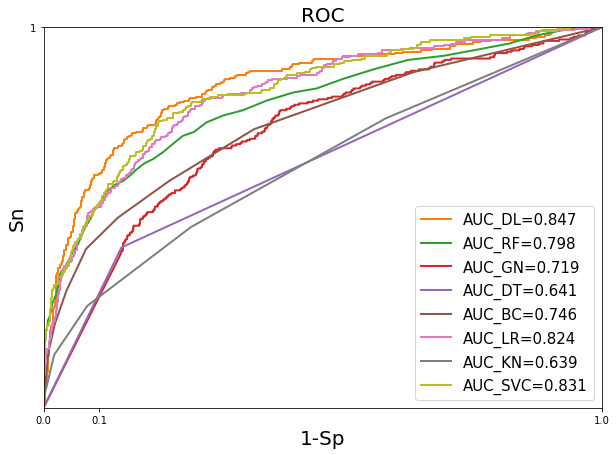

In [11]:
plt.figure(figsize=[10,7])
plt.plot(fpr,tpr,"C1",lw=2,label="AUC_DL=%.3f"%(0.847))

model = torch.load("./Model/m1_RF.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C2",lw=2,label="AUC_RF=%.3f"%roc_auc_score(y_true,y_pred))

model = torch.load("./Model/m1_GN.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C3",lw=2,label="AUC_GN=%.3f"%roc_auc_score(y_true,y_pred))

model = torch.load("./Model/m1_DT.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C4",lw=2,label="AUC_DT=%.3f"%roc_auc_score(y_true,y_pred))

model = torch.load("./Model/m1_BC.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C5",lw=2,label="AUC_BC=%.3f"%roc_auc_score(y_true,y_pred))

model = torch.load("./Model/m1_LR.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C6",lw=2,label="AUC_LR=%.3f"%roc_auc_score(y_true,y_pred))

model = torch.load("./Model/m1_KN.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C7",lw=2,label="AUC_KN=%.3f"%roc_auc_score(y_true,y_pred))

model = torch.load("./Model/m1_SVC.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C8",lw=2,label="AUC_SVC=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("ROC_multiple.pdf")

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator GaussianNB from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invali

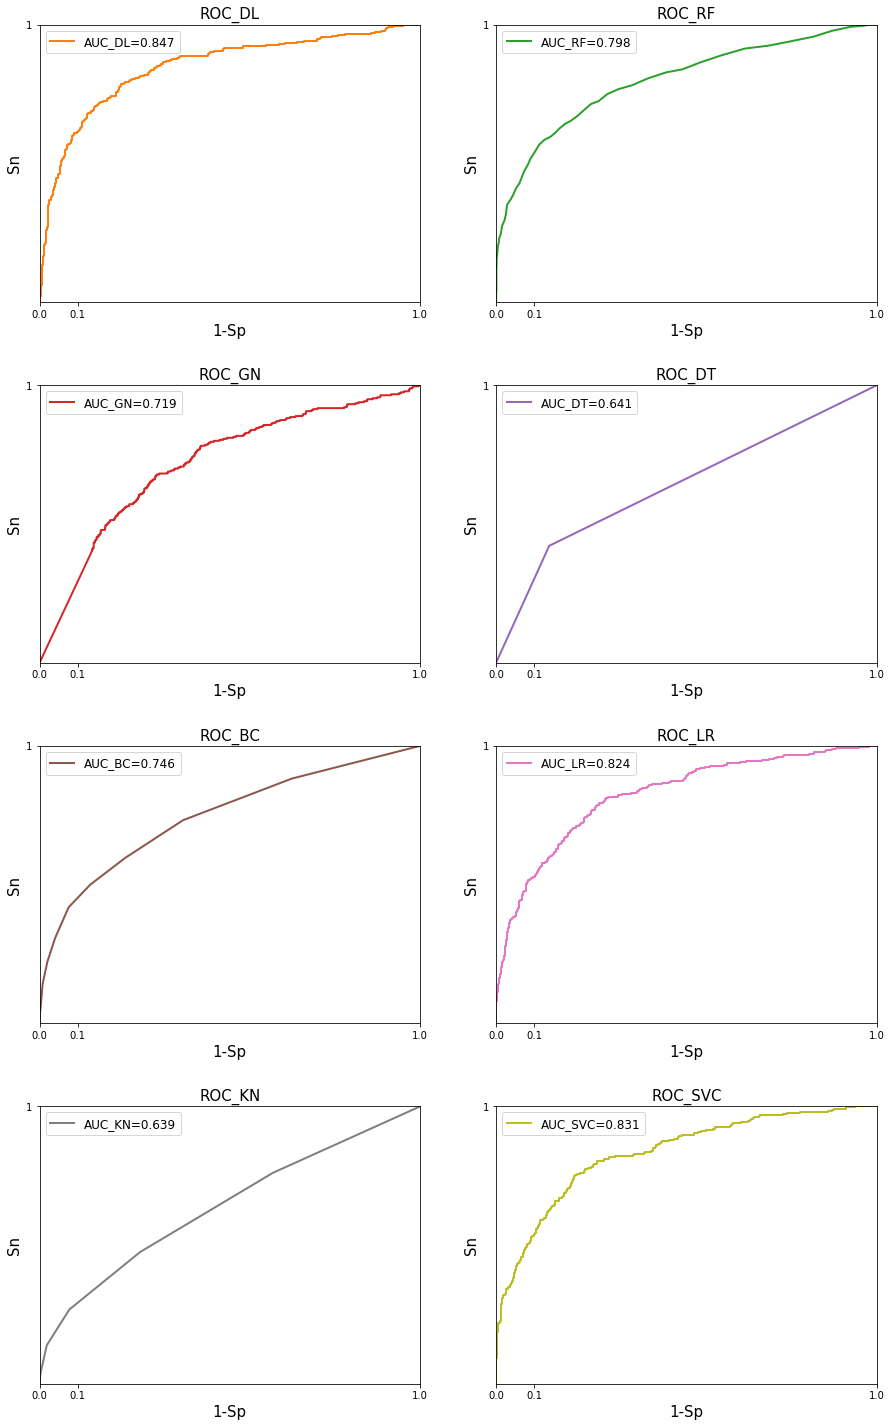

In [12]:
C = ["C1","C2","C3","C4","C5","C6","C7","C8"]
M = ["DL","RF","GN","DT","BC","LR","KN","SVC"]
plt.figure(figsize=[15,25])
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=None,hspace=0.3)
for i in range(8):
    if i == 0:
        plt.subplot(4,2,i+1)
        plt.plot(fpr,tpr,C[i],lw=2,label="AUC_%s=%.3f"%(M[i],0.847))
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([0,0.1,1])
        plt.yticks([1])
        plt.xlabel("1-Sp",fontsize=15)
        plt.ylabel("Sn",fontsize=15)
        plt.title("ROC_%s"%M[i],fontsize=15)
        plt.legend(fontsize=12)
    else:   
        plt.subplot(4,2,i+1)
        model = torch.load("./Model/m1_%s.hdf5"%M[i])
        y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
        roc_auc_score(y_true,y_pred)
        fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
        plt.plot(fpr1,tpr1,C[i],lw=2,label="AUC_%s=%.3f"%(M[i],roc_auc_score(y_true,y_pred)))

        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([0,0.1,1])
        plt.yticks([1])
        plt.xlabel("1-Sp",fontsize=15)
        plt.ylabel("Sn",fontsize=15)
        plt.title("ROC_%s"%M[i],fontsize=15)
        plt.legend(fontsize=12)
#plt.show()
plt.savefig("ROC_single.pdf")

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


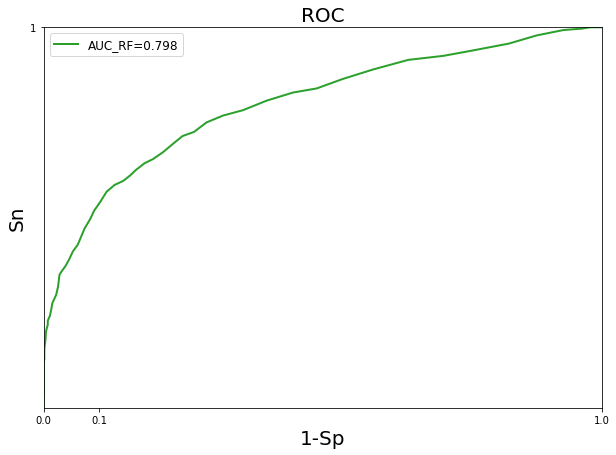

In [69]:
plt.figure(figsize=[10,7])

model = torch.load("./Model/m1_RF.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C2",lw=2,label="AUC_RF=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=12)
plt.show()

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator GaussianNB from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


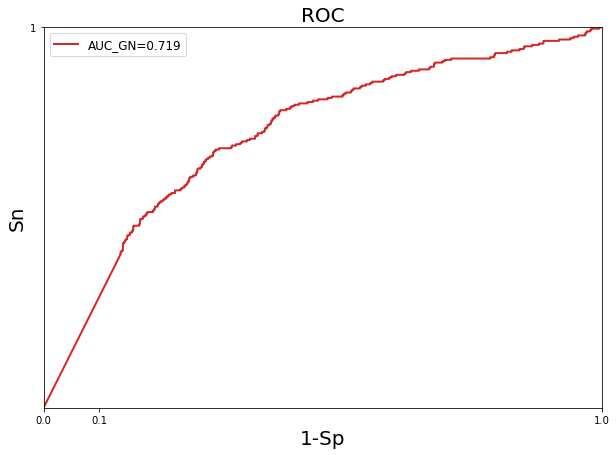

In [71]:
plt.figure(figsize=[10,7])

model = torch.load("./Model/m1_GN.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C3",lw=2,label="AUC_GN=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=12)
plt.show()

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


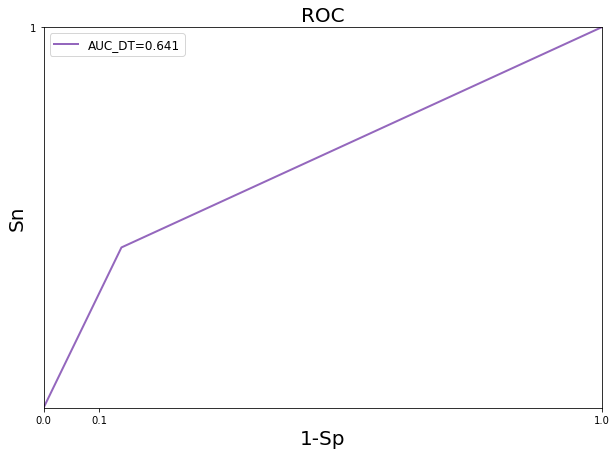

In [72]:
plt.figure(figsize=[10,7])

model = torch.load("./Model/m1_DT.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C4",lw=2,label="AUC_DT=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=12)
plt.show()

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator BaggingClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


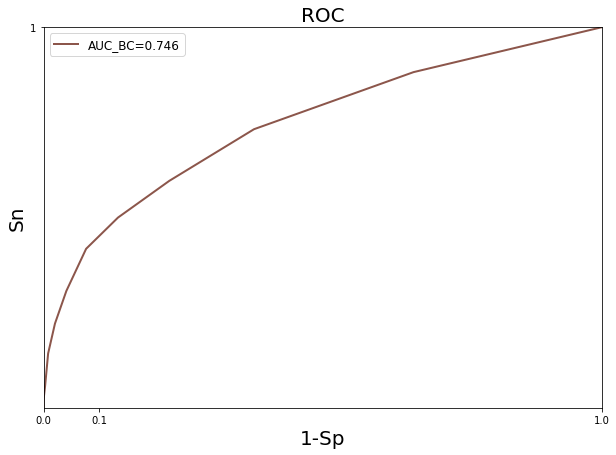

In [73]:
plt.figure(figsize=[10,7])

model = torch.load("./Model/m1_BC.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C5",lw=2,label="AUC_BC=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=12)
plt.show()

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


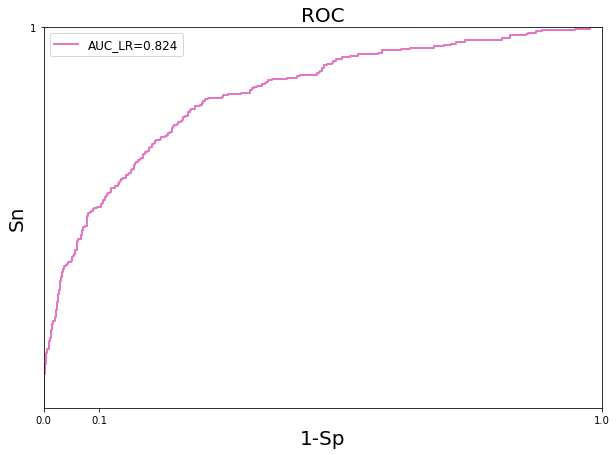

In [74]:
plt.figure(figsize=[10,7])

model = torch.load("./Model/m1_LR.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C6",lw=2,label="AUC_LR=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=12)
plt.show()

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


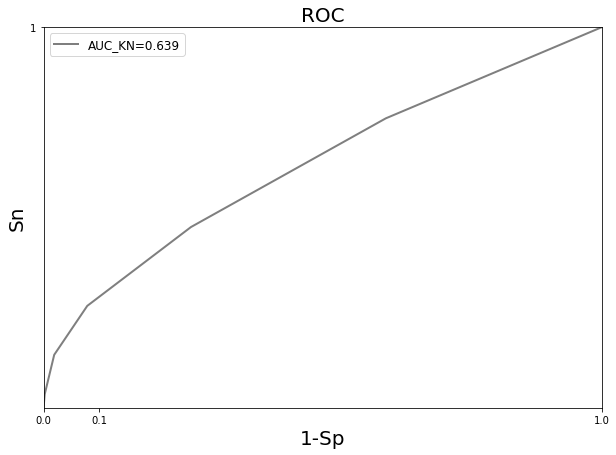

In [75]:
plt.figure(figsize=[10,7])

model = torch.load("./Model/m1_KN.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C7",lw=2,label="AUC_KN=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=12)
plt.show()

C:\Users\zou\miniconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


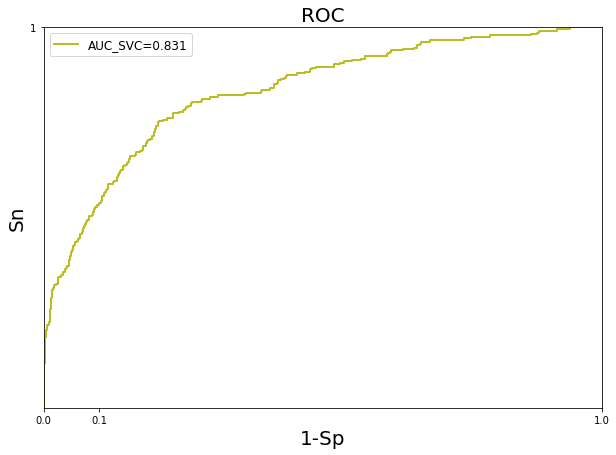

In [76]:
plt.figure(figsize=[10,7])

model = torch.load("./Model/m1_SVC.hdf5")
y_pred = model.predict_proba(x_test_m1[nonredundancy])[:,1]
roc_auc_score(y_true,y_pred)
fpr1,tpr1,thresholds1 = roc_curve(y_true,y_pred)
plt.plot(fpr1,tpr1,"C8",lw=2,label="AUC_SVC=%.3f"%roc_auc_score(y_true,y_pred))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([0,0.1,1])
plt.yticks([1])
plt.xlabel("1-Sp",fontsize=20)
plt.ylabel("Sn",fontsize=20)
plt.title("ROC",fontsize=20)
plt.legend(fontsize=12)
plt.show()